# Model Validation Notebook

This notebook provides a comprehensive validation for all implemented time series generative models (parametric and non-parametric). It covers the entire pipeline from data preprocessing to model training and synthetic data generation, ensuring that each model functions as expected and produces output in the desired format `(R, l, N)`.

## Table of Contents:
1.  [Setup and Imports](#Setup-and-Imports)
2.  [Data Preprocessing](#Data-Preprocessing)
3.  [Parametric Model Validation](#Parametric-Model-Validation)
    *   [Geometric Brownian Motion](#Geometric-Brownian-Motion)
    *   [Ornstein-Uhlenbeck Process](#Ornstein-Uhlenbeck-Process)
    *   [Merton Jump Diffusion](#Merton-Jump-Diffusion)
    *   [Double Exponential Jump Diffusion](#Double-Exponential-Jump-Diffusion)
    *   [GARCH(1,1)](#GARCH-1-1)
    *   [Block Bootstrap](#Block-Bootstrap)
4.  [Non-Parametric Model Validation](#Non-Parametric-Model-Validation)
    *   [TimeGAN](#TimeGAN)
    *   [QuantGAN](#QuantGAN)
    *   [TimeVAE](#TimeVAE)



In [1]:
import sys
import numpy as np
import torch
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

print(f"Project root added to sys.path: {project_root}")

from src.utils.preprocessing_utils import (
    TimeSeriesDataset,
    create_dataloaders,
    preprocess_data
)

from src.utils.configs_utils import get_dataset_cfgs

from src.models.base.base_model import ParametricModel, DeepLearningModel
from src.models.parametric.gbm import GeometricBrownianMotion
from src.models.parametric.ou_process import OrnsteinUhlenbeckProcess
from src.models.parametric.merton_jump_diffusion import MertonJumpDiffusion
from src.models.parametric.garch11 import GARCH11
from src.models.parametric.de_jump_diffusion import DoubleExponentialJumpDiffusion
from src.models.parametric.block_bootstrap import BlockBootstrap

from src.models.non_parametric.time_gan import TimeGAN
from src.models.non_parametric.quant_gan import QuantGAN
from src.models.non_parametric.time_vae import TimeVAE
from src.models.non_parametric.sig_wgan import SigWGAN

print("All necessary modules imported successfully!")

Project root added to sys.path: C:\Users\14165\Downloads\Unified-benchmark-for-SDGFTS-main
All necessary modules imported successfully!


## Data Preprocessing

This section demonstrates how to preprocess a sample dataset (`GOOG.csv`) using the provided utilities and create PyTorch `DataLoader` objects. This data will be used to train and validate our generative models.



In [2]:
nonparametric_cfg, parametric_cfg = get_dataset_cfgs()

In [3]:
# --- Normalized; Non-parametric case; Batched time series ---
print(f"Preprocessing normalized data with config: {nonparametric_cfg}")

train_data_np, valid_data_np, _ = preprocess_data(nonparametric_cfg)

batch_size = 32
train_loader_np, valid_loader_np, _ = create_dataloaders(
    train_data_np, valid_data_np, _,
    batch_size=batch_size,
    train_seed=42,
    valid_seed=123,
    num_workers=0,
    pin_memory=False
)

print(f"\n[Normalized] Train data shape: {train_data_np.shape}")
print(f"[Normalized] Valid data shape: {valid_data_np.shape}")
print(f"[Normalized] Number of training batches: {len(train_loader_np)}")
print(f"[Normalized] Number of validation batches: {len(valid_loader_np)}")

num_samples_real, length, num_channels = train_data_np.shape
print(f"\n[Normalized] Inferred model output dimensions: length={length}, num_channels={num_channels}")


Preprocessing normalized data with config: {'ticker': 'AAPL', 'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\AAPL\\AAPL.csv', 'valid_ratio': 0.1, 'test_ratio': 0.1, 'do_transformation': True, 'seed': 42}
Preprocessing data for AAPL

[Normalized] Train data shape: (9035, 13, 4)
[Normalized] Valid data shape: (1129, 13, 4)
[Normalized] Number of training batches: 283
[Normalized] Number of validation batches: 36

[Normalized] Inferred model output dimensions: length=13, num_channels=4


In [6]:
# --- Unnormalized; Parametric Case; Use full time series ---
print(f"Preprocessing full dataset with configs: {parametric_cfg}")

train_data_para, valid_data_para, _ = preprocess_data(parametric_cfg)

print(f"\n[Unnormalized] Type of train_data_para: {type(train_data_para)}")
print(f"[Unnormalized] Type of valid_data_para: {type(valid_data_para)}")
print(f"[Unnormalized] Train data shape: {train_data_para.shape}")
print(f"[Unnormalized] Valid data shape: {valid_data_para.shape}")

length, num_channels = train_data_para.shape
print(f"\n[Unnormalized] Inferred model output dimensions: length={length}, num_channels={num_channels}")

Preprocessing full dataset with configs: {'ticker': 'AAPL', 'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\AAPL\\AAPL.csv', 'valid_ratio': 0.1, 'test_ratio': 0.1, 'is_parametric': True, 'do_transformation': True, 'seed': 42}
Preprocessing data for AAPL

[Unnormalized] Type of train_data_para: <class 'torch.Tensor'>
[Unnormalized] Type of valid_data_para: <class 'torch.Tensor'>
[Unnormalized] Train data shape: torch.Size([9044, 4])
[Unnormalized] Valid data shape: torch.Size([1131, 4])

[Unnormalized] Inferred model output dimensions: length=9044, num_channels=4


## Stochastic Model Validation

This section validates the functionality of each stochastic time series generative model. For each model, we will:
1.  Instantiate the model with appropriate parameters.
2.  Train the model using the preprocessed training data.
3.  Generate new synthetic time series samples.
4.  Verify the shape and basic statistics of the generated data.



In [8]:
def plot_outputs(train_data_para, generated_data, num_generated_samples, length):
    """
    Assumes train_data_para and generated_data have financial channels only (no time column).
      Channel 0: Open
      Channel 1: Close
      Channel 2: High
      Channel 3: Low
    Plots each channel's statistics and overlay vs generated samples.

    Note:
        - Blue line: the real training data.
        - Gray lines: each generated/simulated sample.
    """
    channel_names = ["Open", "Close", "High", "Low"]
    num_channels = generated_data.shape[-1]
    assert num_channels == len(channel_names), f"Expected {len(channel_names)} channels, got {num_channels}"

    for c in range(num_channels):
        chan_data = generated_data[..., c]
        min_val = chan_data.min().item()
        max_val = chan_data.max().item()
        mean_val = chan_data.mean().item()
        print(f"{channel_names[c]} (channel {c}): min={min_val:.4f}, max={max_val:.4f}, mean={mean_val:.4f}")

        plt.figure(figsize=(12, 5))
        y_real = train_data_para[:, c].cpu().numpy() if hasattr(train_data_para, "cpu") else train_data_para[:, c]
        plt.plot(range(length), y_real, label="Original Train", color='blue', linewidth=2)

        for i in range(num_generated_samples):
            y_fake = generated_data[i, :, c].cpu().numpy() if hasattr(generated_data, "cpu") else generated_data[i, :, c]
            plt.plot(
                range(length), y_fake,
                alpha=0.7, linestyle="--", color='gray',
                label="Generated" if i == 0 else None)
        plt.title(f"{channel_names[c]}: Original vs Generated Samples")
        plt.xlabel("Time Step")
        plt.ylabel(channel_names[c])
        plt.legend()
        plt.tight_layout()
        plt.show()

### Geometric Brownian Motion




Validating Geometric Brownian Motion (GBM)
GBM Model instantiated: <src.models.parametric.gbm.GeometricBrownianMotion object at 0x000001E0D0934200>
Fitting GBM model...
GBM Parameters: {'mu': tensor([0.0010, 0.0010, 0.0010, 0.0011]), 'sigma': tensor([0.0299, 0.0268, 0.0288, 0.0300])}
Generated GBM data shape: torch.Size([1, 9044, 4])
GBM: Generated data shape is correct.
Open (channel 0): min=-0.1030, max=0.1218, mean=0.0006


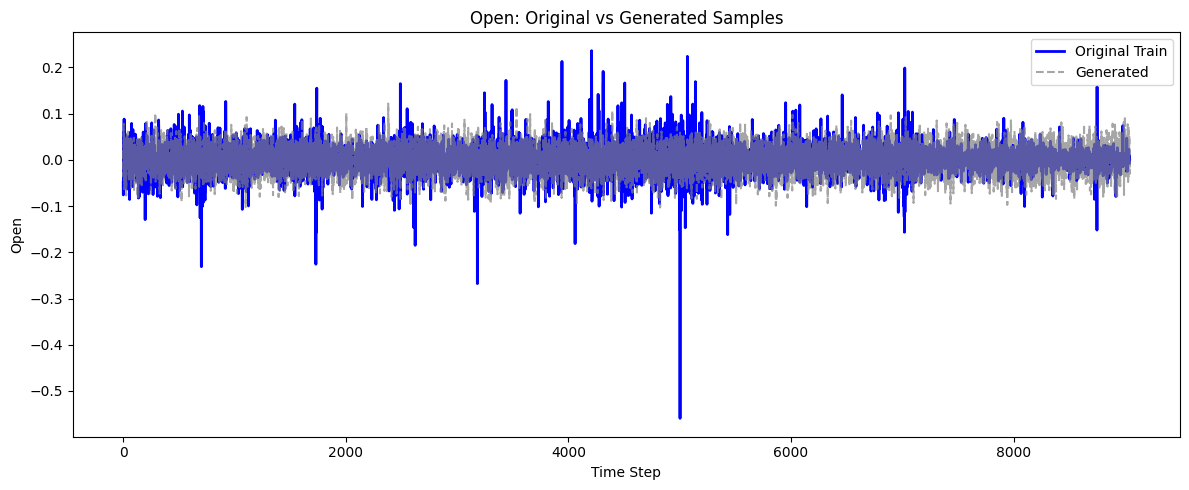

Close (channel 1): min=-0.0980, max=0.0967, mean=0.0005


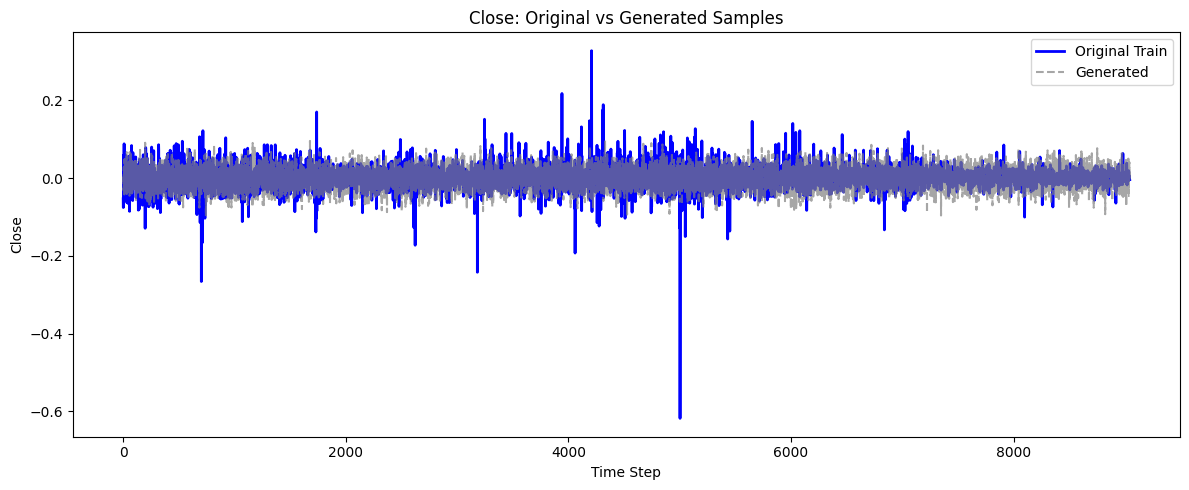

High (channel 2): min=-0.1103, max=0.1078, mean=0.0006


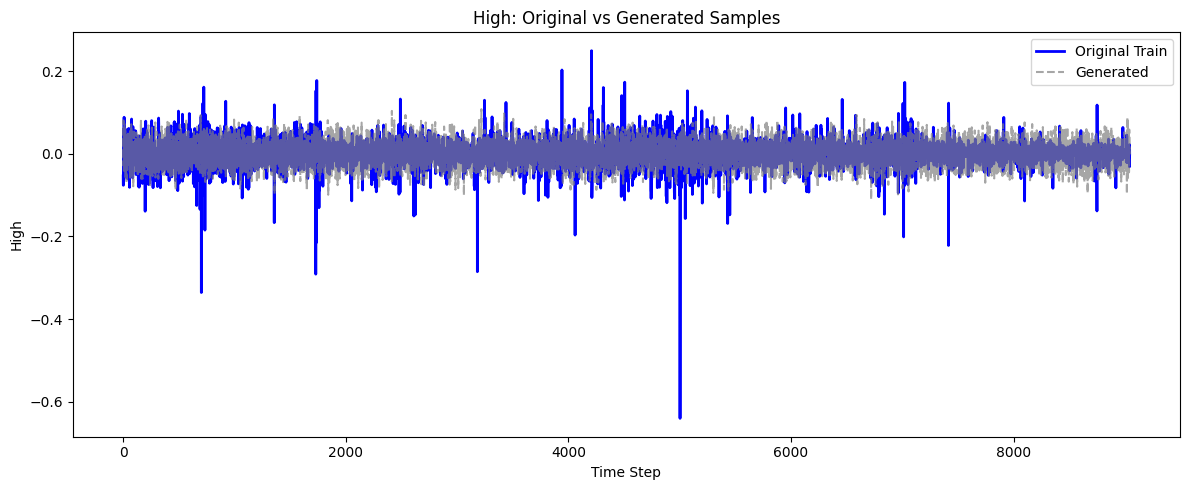

Low (channel 3): min=-0.1202, max=0.1051, mean=0.0004


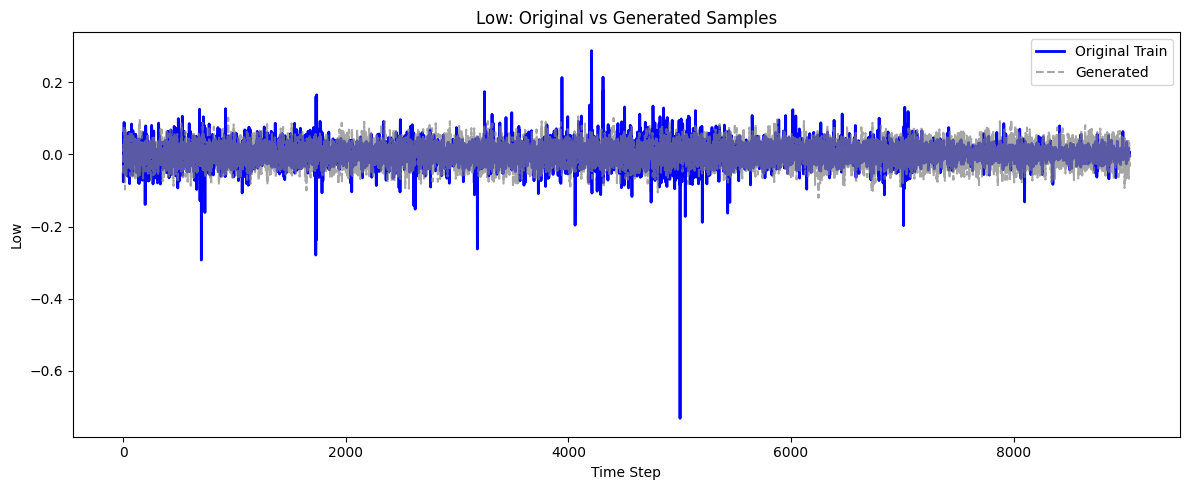

In [9]:
print("\n" + "=" * 50)
print("Validating Geometric Brownian Motion (GBM)")
print("=" * 50)


length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

gbm_model = GeometricBrownianMotion(length=length, num_channels=num_channels)
print(f"GBM Model instantiated: {gbm_model}")

print("Fitting GBM model...")
gbm_parameters = gbm_model.fit(train_data_para)
print(f"GBM Parameters: {gbm_parameters}")

num_generated_samples = 1
gbm_generated_data = gbm_model.generate(num_generated_samples)
print(f"Generated GBM data shape: {gbm_generated_data.shape}")

assert gbm_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"GBM: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {gbm_generated_data.shape}"
print("GBM: Generated data shape is correct.")

plot_outputs(train_data_para, gbm_generated_data, num_generated_samples, length)

### Ornstein-Uhlenbeck Process




Validating Ornstein-Uhlenbeck (O-U) Process
O-U Model instantiated: <src.models.parametric.ou_process.OrnsteinUhlenbeckProcess object at 0x00000256BC02ECC0>
Fitting O-U model...
Generated O-U data shape: torch.Size([1, 9610, 4])
O-U: Generated data shape is correct.
Open (channel 0): min=-0.1108, max=0.1140, mean=0.0007


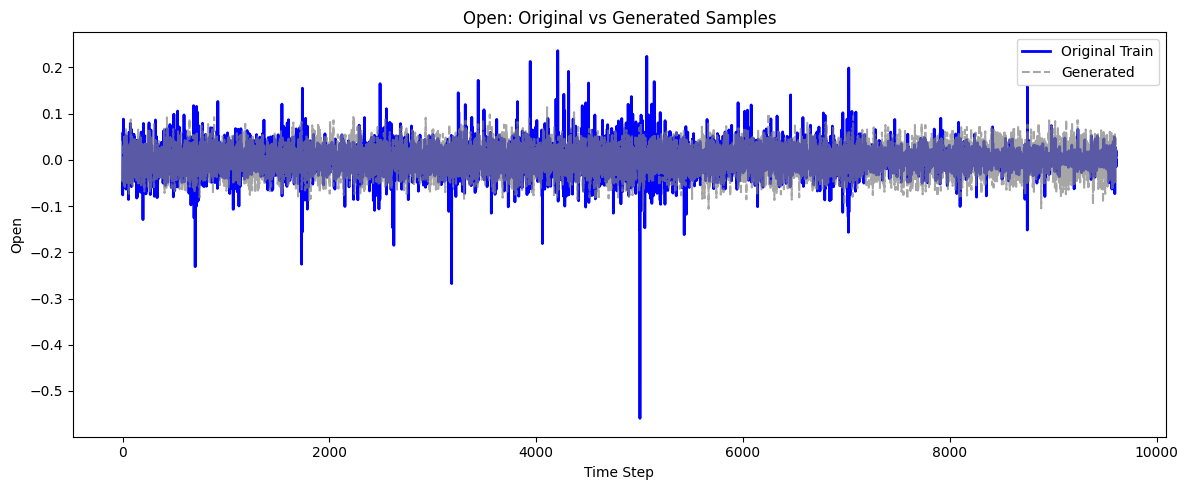

Close (channel 1): min=-0.1120, max=0.1150, mean=-0.0000


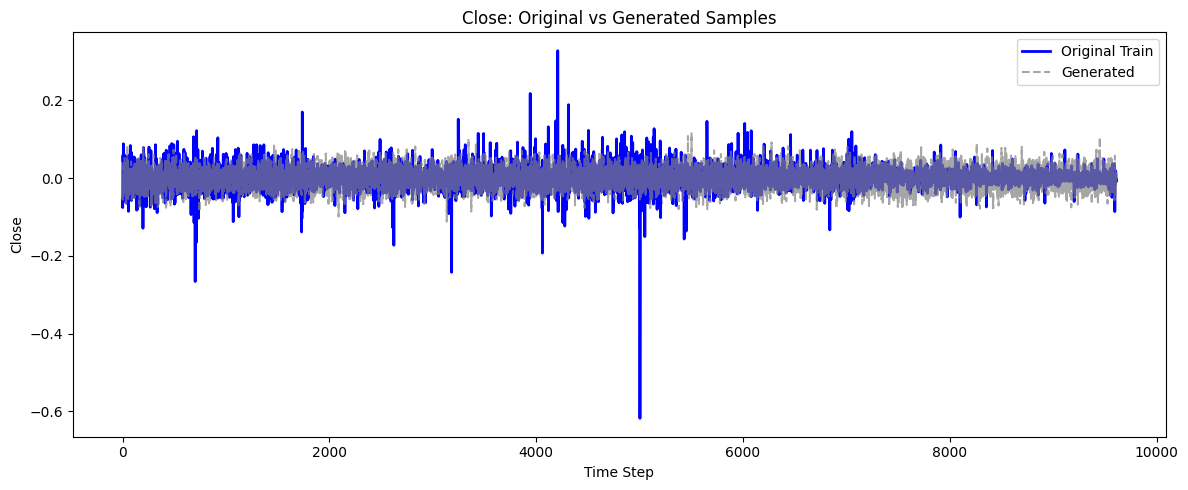

High (channel 2): min=-0.1045, max=0.1306, mean=0.0005


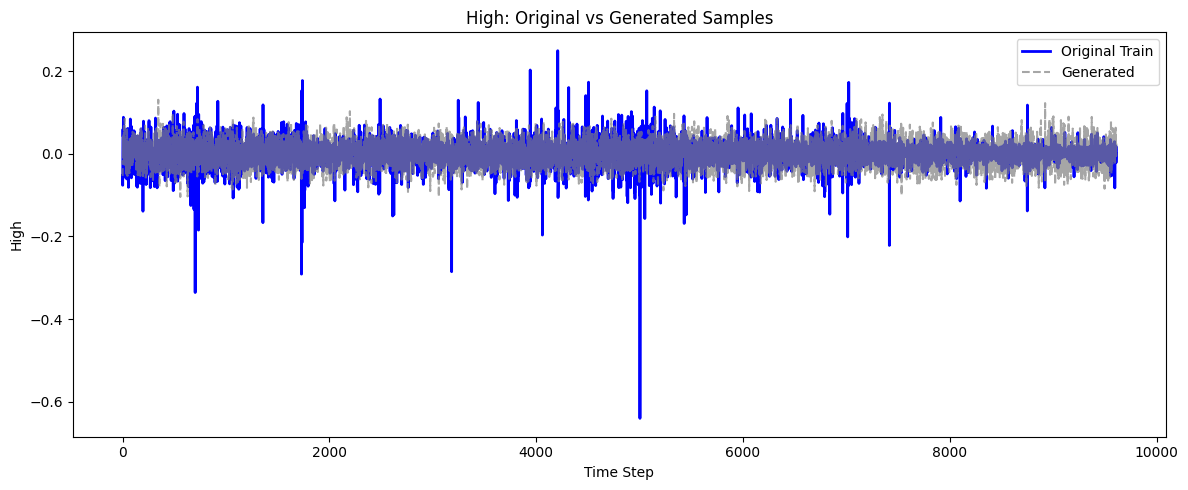

Low (channel 3): min=-0.1212, max=0.1201, mean=0.0005


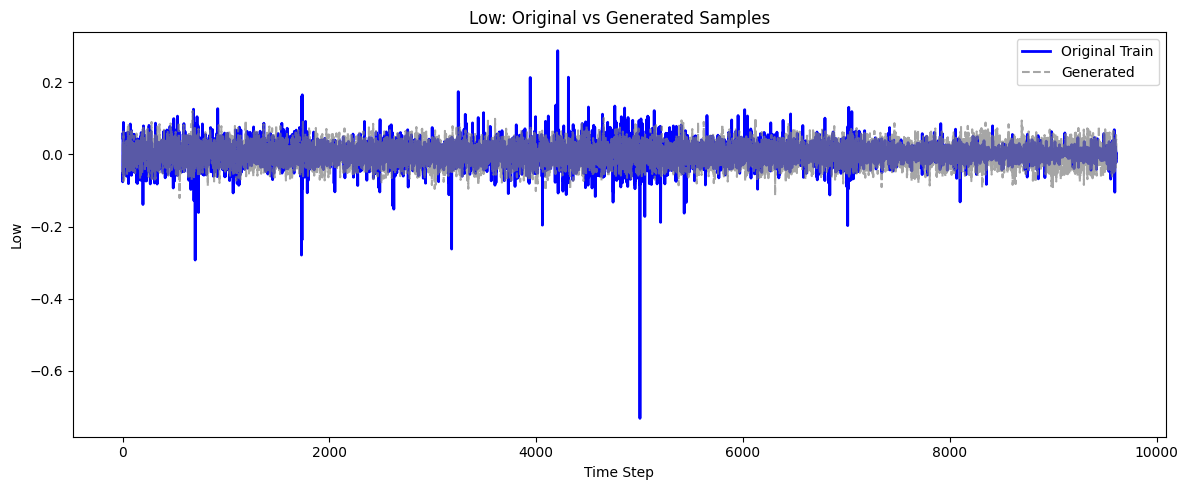

In [ ]:
print("\n" + "=" * 50)
print("Validating Ornstein-Uhlenbeck (O-U) Process")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

ou_model = OrnsteinUhlenbeckProcess(length=length, num_channels=num_channels)
print(f"O-U Model instantiated: {ou_model}")

print("Fitting O-U model...")
ou_model.fit(train_data_para)

num_generated_samples = 1
ou_generated_data = ou_model.generate(num_generated_samples)
print(f"Generated O-U data shape: {ou_generated_data.shape}")

assert ou_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"O-U: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {ou_generated_data.shape}"
print("O-U: Generated data shape is correct.")

plot_outputs(train_data_para, ou_generated_data, num_generated_samples, length)

### Merton Jump Diffusion


Validating Merton Jump Diffusion (MJD)
MJD Model instantiated: <src.models.parametric.merton_jump_diffusion.MertonJumpDiffusion object at 0x00000256BC486210>
Fitting MJD model...
Generated MJD data shape: torch.Size([1, 9610, 4])
MJD: Generated data shape is correct.
Open (channel 0): min=-0.4803, max=0.3320, mean=0.0003


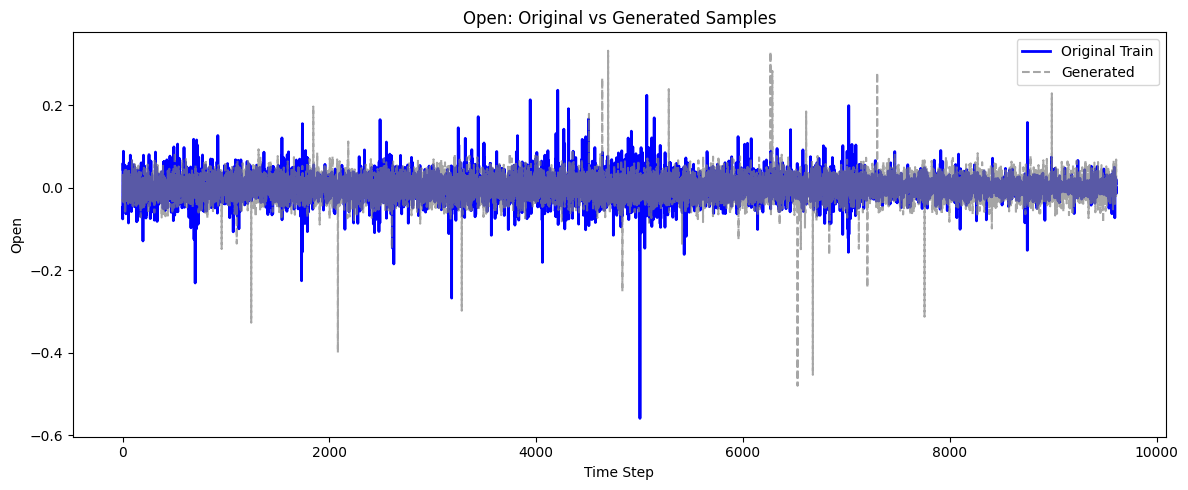

Close (channel 1): min=-0.4600, max=0.3099, mean=0.0007


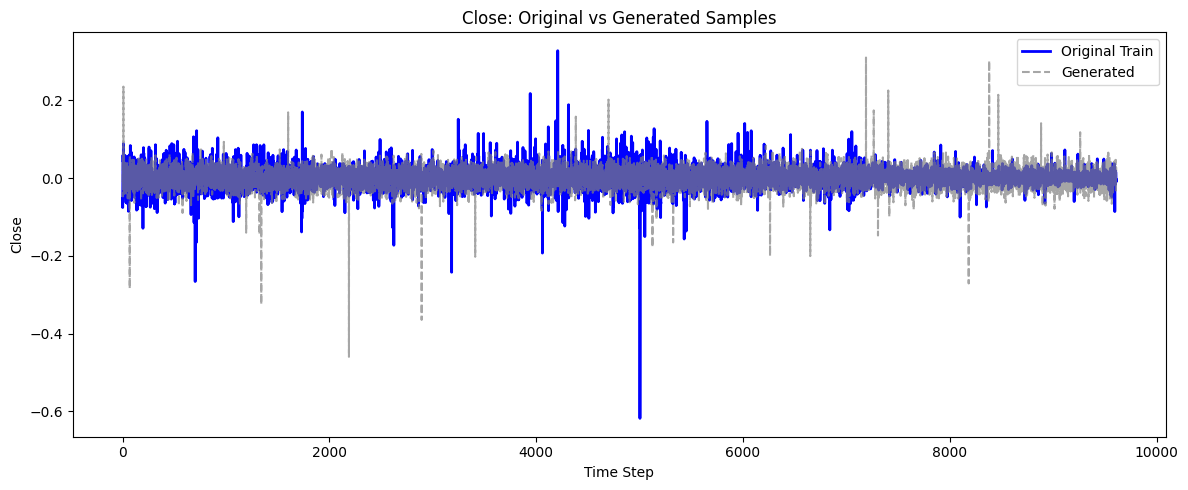

High (channel 2): min=-0.5785, max=0.3924, mean=0.0005


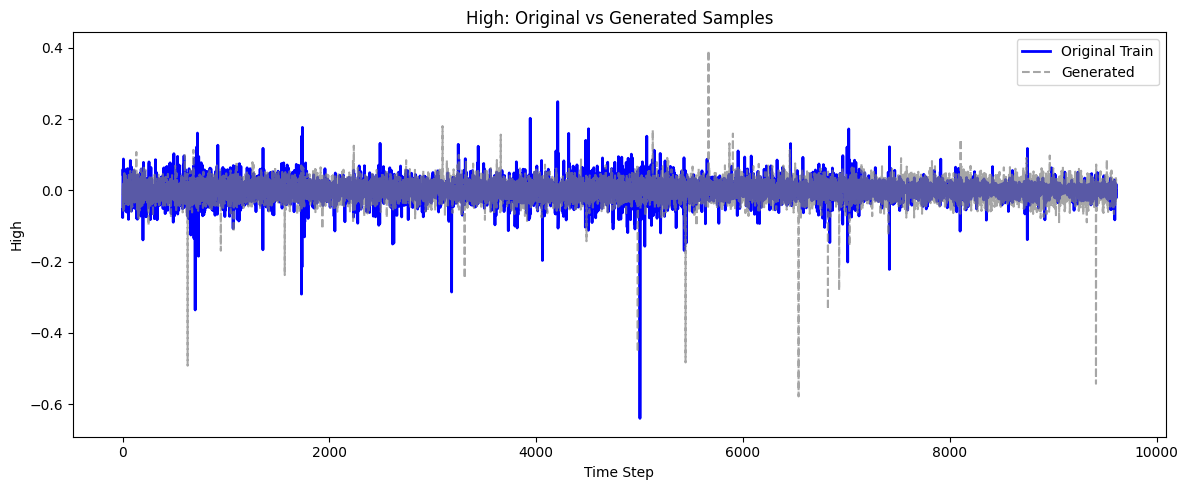

Low (channel 3): min=-0.4585, max=0.4813, mean=0.0005


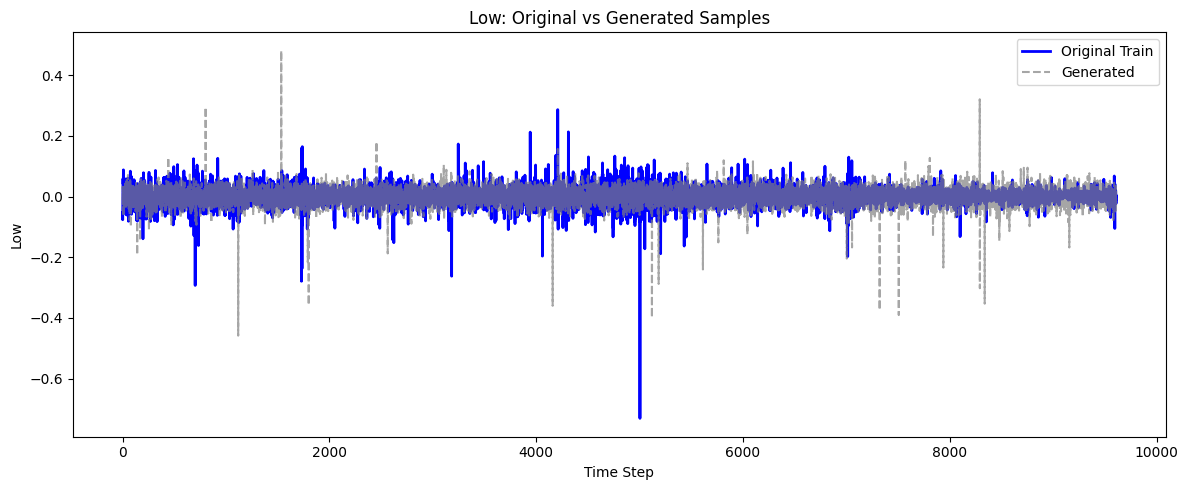

In [ ]:
print("\n" + "=" * 50)
print("Validating Merton Jump Diffusion (MJD)")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

mjd_model = MertonJumpDiffusion(length=length, num_channels=num_channels)
print(f"MJD Model instantiated: {mjd_model}")

print("Fitting MJD model...")
mjd_model.fit(train_data_para)

num_generated_samples = 1
mjd_generated_data = mjd_model.generate(num_generated_samples)
print(f"Generated MJD data shape: {mjd_generated_data.shape}")

assert mjd_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"MJD: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {mjd_generated_data.shape}"
print("MJD: Generated data shape is correct.")

plot_outputs(train_data_para, mjd_generated_data, num_generated_samples, length)

### GARCH(1, 1)


Validating GARCH(1,1)
GARCH(1,1) Model instantiated: <src.models.parametric.garch11.GARCH11 object at 0x00000256BC4D1040>
Fitting GARCH(1,1) model...
Channel 1/4 fitted: omega=8.708181e-06, alpha=7.345661e-02, beta=9.209154e-01
Channel 2/4 fitted: omega=3.202405e-06, alpha=4.705072e-02, beta=9.515030e-01
Channel 3/4 fitted: omega=1.357276e-05, alpha=1.095739e-01, beta=8.851122e-01
Channel 4/4 fitted: omega=5.785499e-06, alpha=7.114597e-02, beta=9.279161e-01
Generated GARCH(1,1) data shape: (1, 9610, 4)
GARCH(1,1): Generated data shape is correct.
Open (channel 0): min=-0.2141, max=0.2746, mean=0.0001


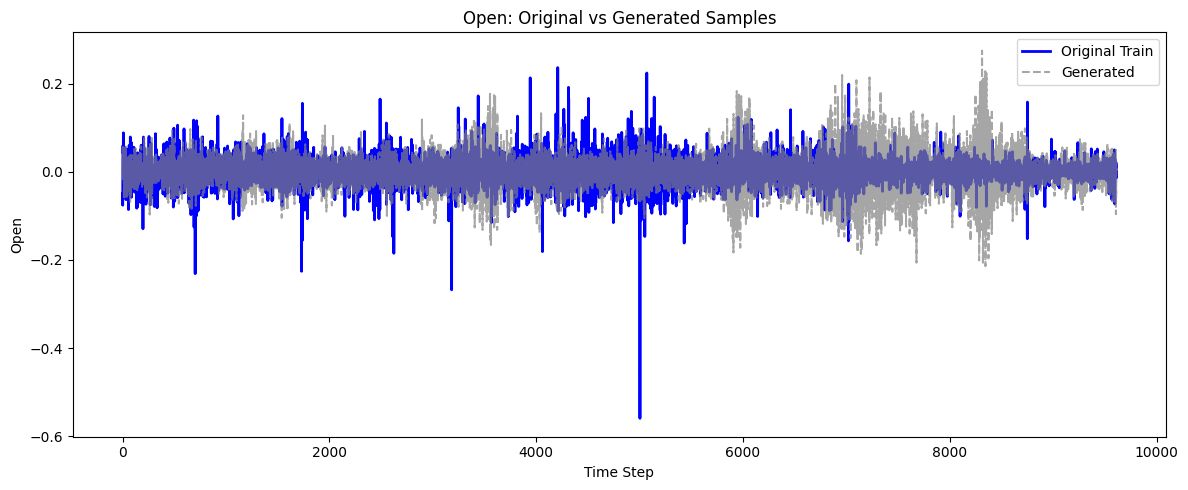

Close (channel 1): min=-0.2242, max=0.2202, mean=0.0006


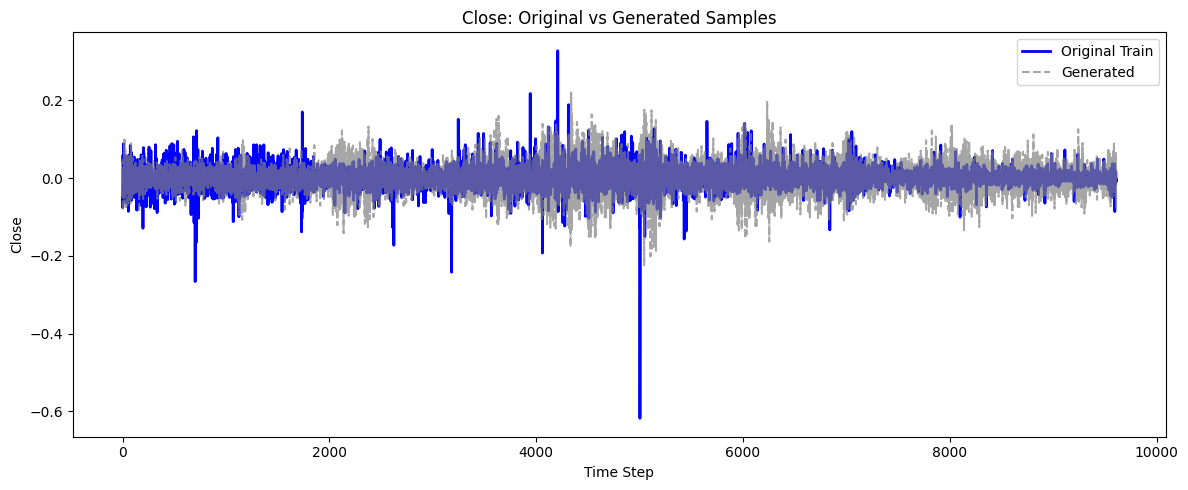

High (channel 2): min=-0.2010, max=0.2277, mean=-0.0003


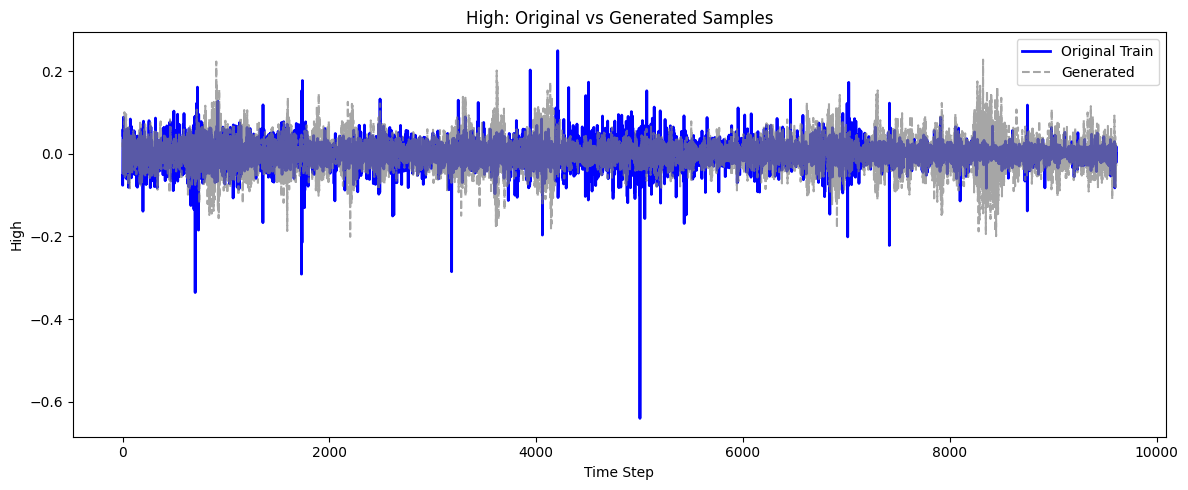

Low (channel 3): min=-0.6430, max=0.6901, mean=-0.0011


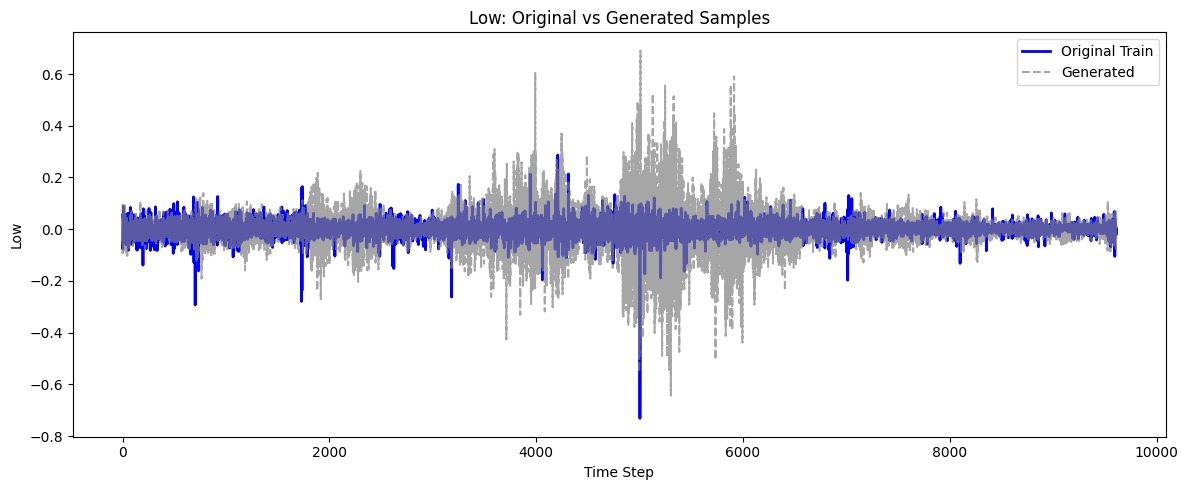

In [ ]:
print("\n" + "=" * 50)
print("Validating GARCH(1,1)")
print("=" * 50)

# Extract length and number of channels from training data
length, num_channels = train_data_para.shape

garch_model = GARCH11()
print(f"GARCH(1,1) Model instantiated: {garch_model}")

print("Fitting GARCH(1,1) model...")
garch_model.fit(train_data_para)

num_generated_samples = 1
garch_generated_data = garch_model.generate(num_generated_samples)
print(f"Generated GARCH(1,1) data shape: {garch_generated_data.shape}")

assert garch_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"GARCH(1,1): Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {garch_generated_data.shape}"
print("GARCH(1,1): Generated data shape is correct.")

plot_outputs(train_data_para, garch_generated_data, num_generated_samples, length)


### Double Exponential Jump Diffusion


Validating Double Exponential Jump Diffusion (DEJD)
DEJD Model instantiated: <src.models.parametric.de_jump_diffusion.DoubleExponentialJumpDiffusion object at 0x00000256BC35DB50>
Fitting DEJD model...
Generated DEJD data shape: torch.Size([1, 9610, 4])
DEJD: Generated data shape is correct.
Open (channel 0): min=-1.7027, max=0.5204, mean=0.0004


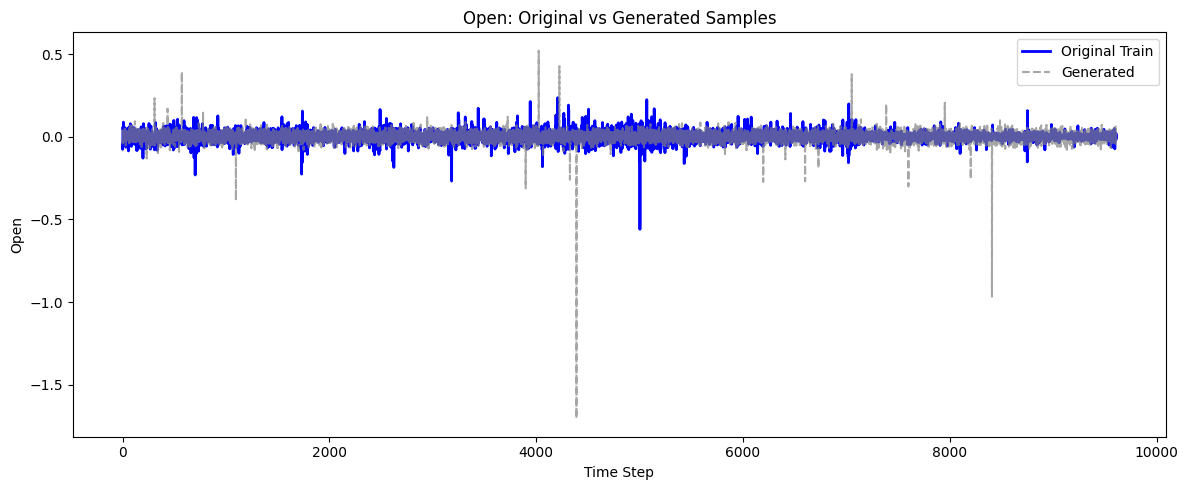

Close (channel 1): min=-0.9243, max=0.7110, mean=0.0007


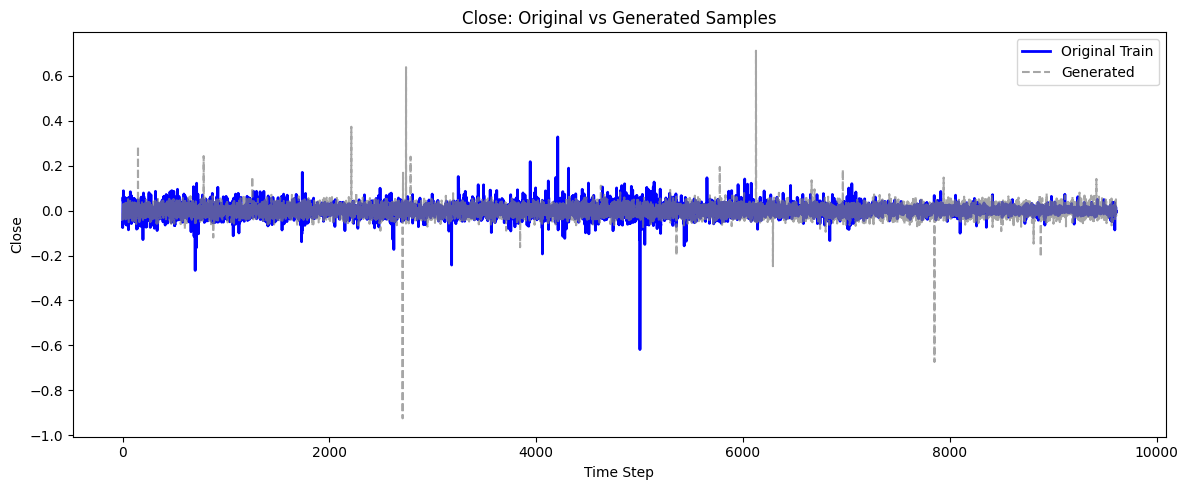

High (channel 2): min=-0.7584, max=1.1390, mean=0.0006


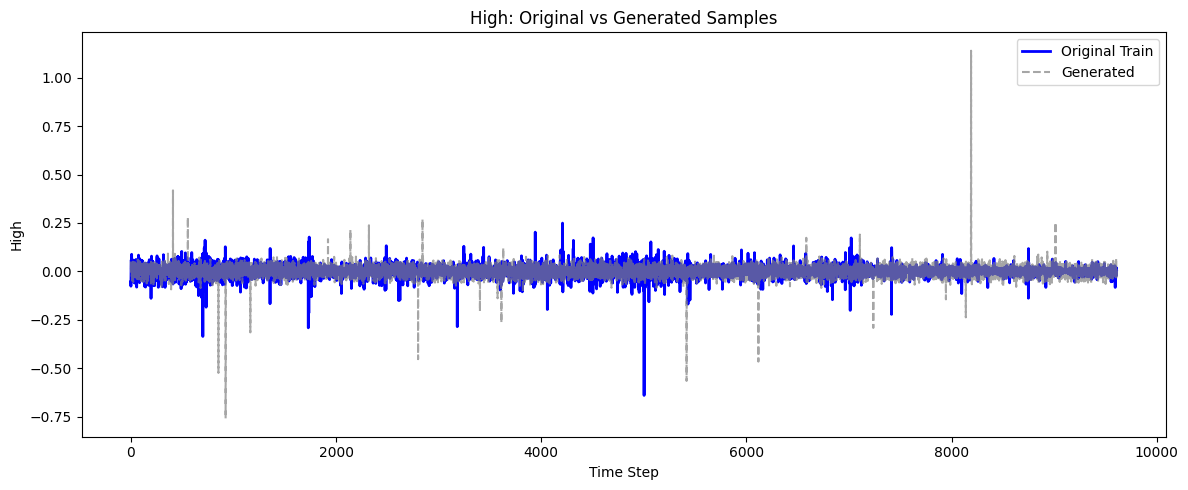

Low (channel 3): min=-0.8515, max=0.6298, mean=0.0008


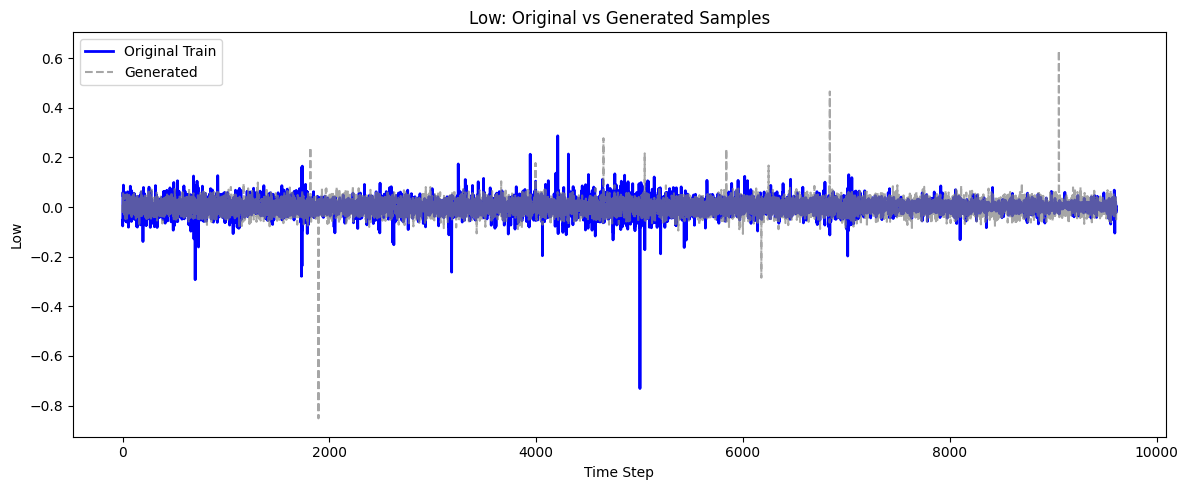

In [ ]:
print("\n" + "=" * 50)
print("Validating Double Exponential Jump Diffusion (DEJD)")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

dejd_model = DoubleExponentialJumpDiffusion(length=length, num_channels=num_channels)
print(f"DEJD Model instantiated: {dejd_model}")

print("Fitting DEJD model...")
dejd_model.fit(train_data_para)

num_generated_samples = 1
dejd_generated_data = dejd_model.generate(num_generated_samples)
print(f"Generated DEJD data shape: {dejd_generated_data.shape}")

assert dejd_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"DEJD: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {dejd_generated_data.shape}"
print("DEJD: Generated data shape is correct.")

plot_outputs(train_data_para, dejd_generated_data, num_generated_samples, length)


Validating Double Exponential Jump Diffusion (DEJD)
DEJD Model instantiated: <src.models.parametric.de_jump_diffusion.DoubleExponentialJumpDiffusion object at 0x00000256BC4876E0>
Fitting DEJD model...
Generated DEJD data shape: torch.Size([1, 9610, 4])
DEJD: Generated data shape is correct.
Open (channel 0): min=-0.4833, max=0.6505, mean=0.0006


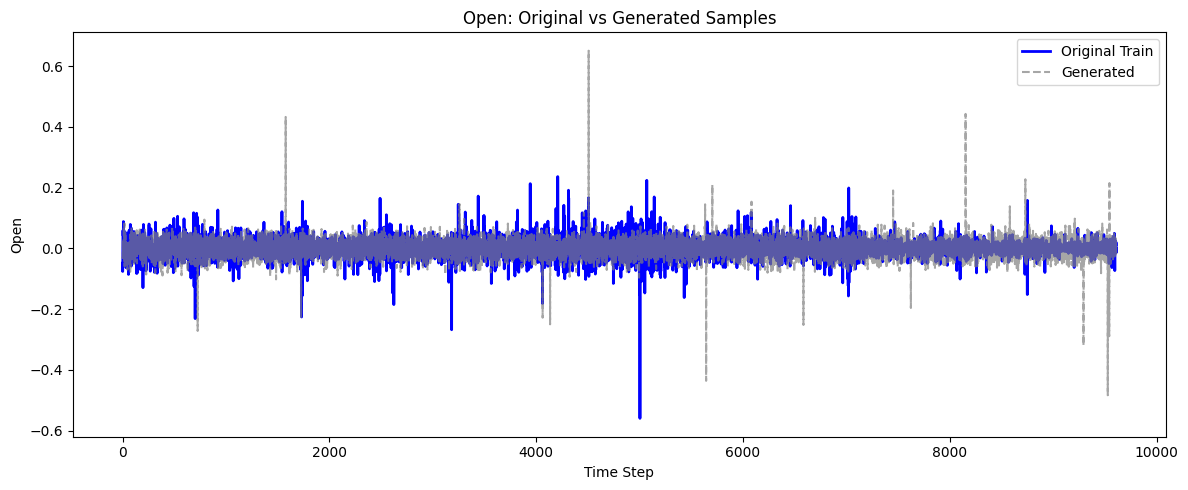

Close (channel 1): min=-0.5413, max=0.4735, mean=0.0007


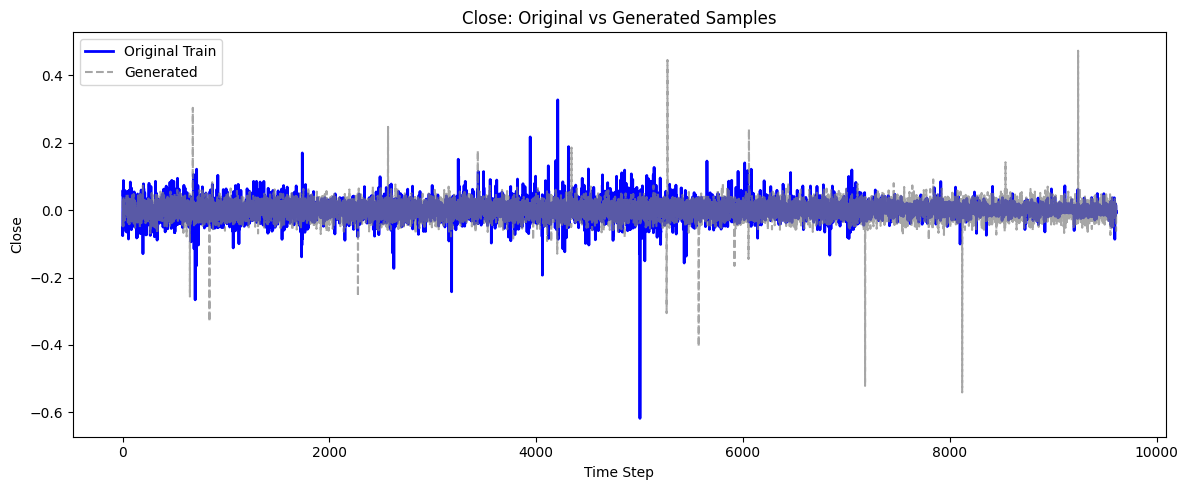

High (channel 2): min=-0.4871, max=0.5505, mean=0.0005


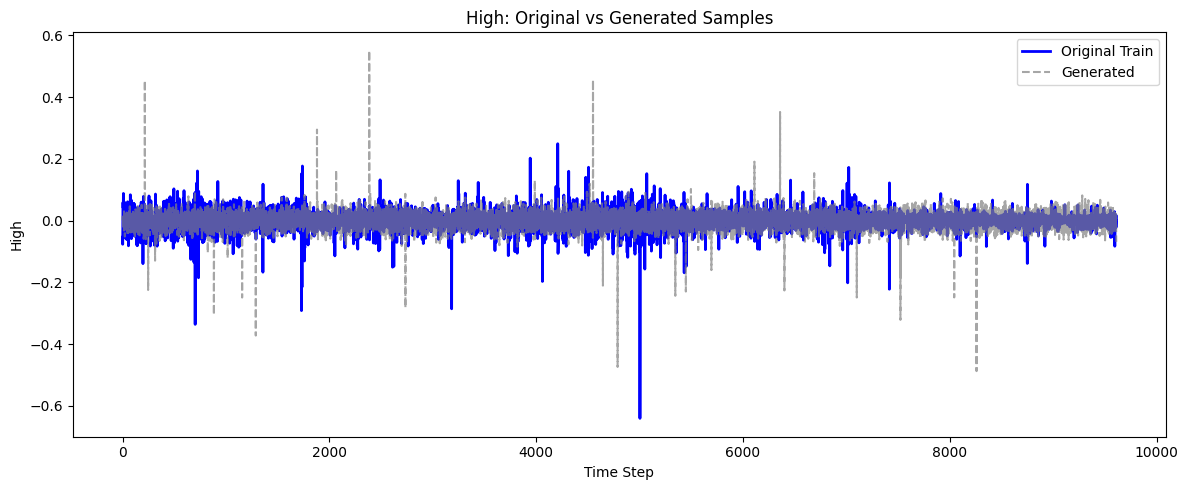

Low (channel 3): min=-0.7782, max=0.6149, mean=0.0008


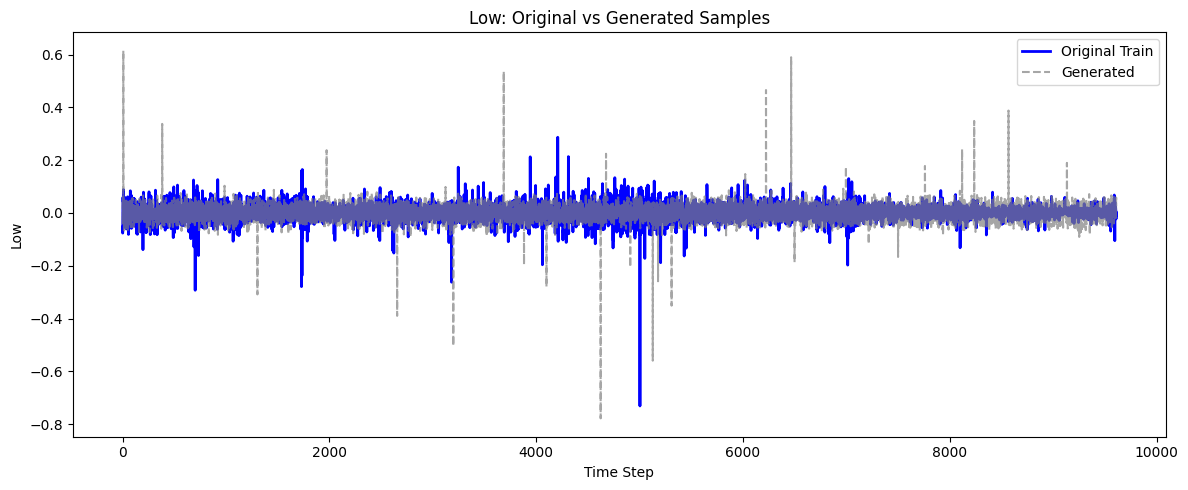

In [ ]:
print("\n" + "=" * 50)
print("Validating Double Exponential Jump Diffusion (DEJD)")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

dejd_model = DoubleExponentialJumpDiffusion(length=length, num_channels=num_channels)
print(f"DEJD Model instantiated: {dejd_model}")

print("Fitting DEJD model...")
dejd_model.fit(train_data_para)

num_generated_samples = 1
dejd_generated_data = dejd_model.generate(num_generated_samples)
print(f"Generated DEJD data shape: {dejd_generated_data.shape}")

assert dejd_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"DEJD: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {dejd_generated_data.shape}"
print("DEJD: Generated data shape is correct.")

plot_outputs(train_data_para, dejd_generated_data, num_generated_samples, length)

## Deep Learning Model Validation

This section validates the functionality of each deep learning time series generative model. For each model, we will:
1.  Instantiate the model with appropriate parameters.
2.  Train the model using the preprocessed training data.
3.  Generate new synthetic time series samples.
4.  Verify the shape and basic statistics of the generated data.

Note: GAN training can be unstable and convergence is not guaranteed with simple validation. This is primarily to check code execution and output format.



In [ ]:
def plot_model_simulations_mean_dt(
    model,
    num_simulations=10, 
    sequence_length=100, 
    feature_idx=None
):
    """
    Generate and plot multiple deep learning model simulations on uniform linear time steps.
    Supports any model that implements a .generate(num_samples, seq_length=...) method and
    outputs tensors of shape (R, l, N).
    """
    if hasattr(model, "eval"):
        model.eval()

    times = np.arange(sequence_length)
    sims = []

    for _ in range(num_simulations):
        with torch.no_grad():
            fake_series = model.generate(num_samples=1, seq_len=sequence_length)
        if isinstance(fake_series, torch.Tensor):
            fake_series = fake_series.cpu().numpy()
        fake_series = fake_series[0]
        sims.append(fake_series)

    sims = np.stack(sims, axis=0)
    num_channels = sims.shape[2]

    if feature_idx is None:
        channels_to_plot = range(num_channels)
    else:
        if feature_idx >= num_channels:
            raise ValueError(f"feature_idx={feature_idx} out of bounds for {num_channels} channels")
        channels_to_plot = [feature_idx]

    for ch in channels_to_plot:
        plt.figure(figsize=(12, 6))
        for i in range(num_simulations):
            plt.plot(times, sims[i, :, ch], label=f'Sim {i+1}', alpha=0.7)
        plt.title(f'{num_simulations} Model Simulations (Channel {ch})')
        plt.xlabel("Time Index")
        plt.ylabel("Feature Value (Normalized)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


### TimeGAN



In [ ]:
seq_length = train_data_np.shape[1]
num_channels = train_data_np.shape[2]

print("\n" + "=" * 50)
print("Training TimeGAN")
print("=" * 50)

time_gan = TimeGAN(
    input_dim=num_channels
)

print(f"TimeGAN model initialized on device: {time_gan.device}")

print("Training TimeGAN model...")
time_gan.fit(train_loader_np, epochs=10)
print("TimeGAN training complete.")



Training TimeGAN
TimeGAN model initialized on device: cpu
Training TimeGAN model...
Epoch 1/10 — Phase 1: ER pretrain
Epoch 1/10 — Phase 2: Supervisor pretrain
Epoch 1/10 — Phase 3: Adversarial training
Epoch 1 summary: ER=0.0002, S=0.0014, D=1.3713, G=0.7910
Epoch 2/10 — Phase 1: ER pretrain
Epoch 2/10 — Phase 2: Supervisor pretrain
Epoch 2/10 — Phase 3: Adversarial training
Epoch 2 summary: ER=0.0000, S=0.0021, D=1.4818, G=0.5746
Epoch 3/10 — Phase 1: ER pretrain
Epoch 3/10 — Phase 2: Supervisor pretrain
Epoch 3/10 — Phase 3: Adversarial training
Epoch 3 summary: ER=0.0000, S=0.0011, D=1.4391, G=0.6770
Epoch 4/10 — Phase 1: ER pretrain
Epoch 4/10 — Phase 2: Supervisor pretrain
Epoch 4/10 — Phase 3: Adversarial training
Epoch 4 summary: ER=0.0000, S=0.0012, D=1.4254, G=0.6399
Epoch 5/10 — Phase 1: ER pretrain
Epoch 5/10 — Phase 2: Supervisor pretrain
Epoch 5/10 — Phase 3: Adversarial training
Epoch 5 summary: ER=0.0000, S=0.0010, D=1.4033, G=0.6872
Epoch 6/10 — Phase 1: ER pretrain
E

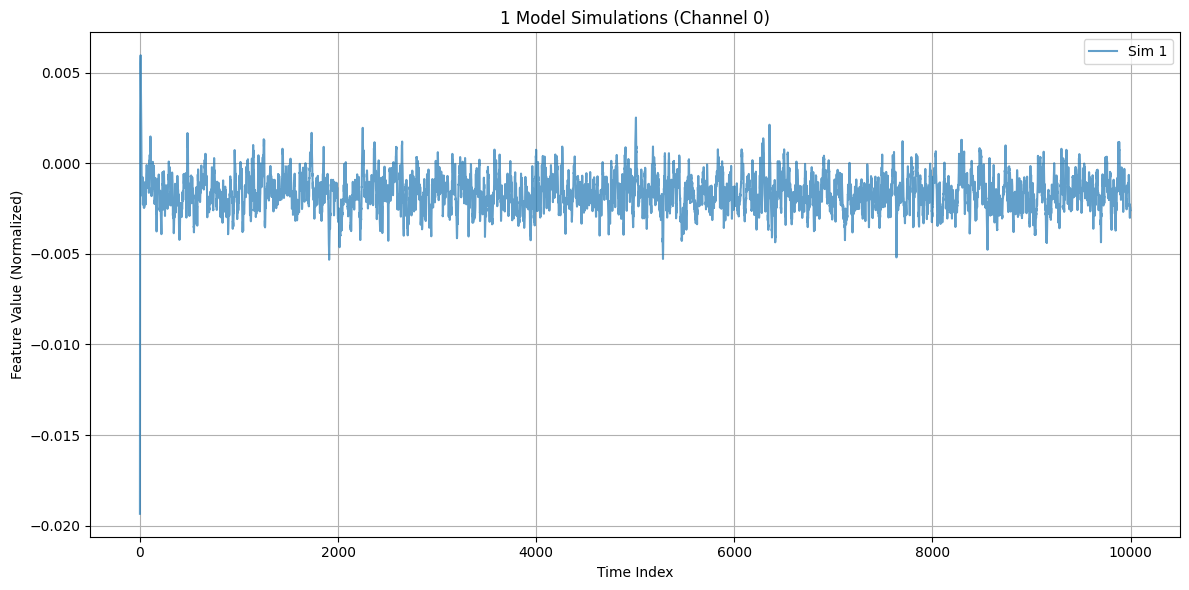

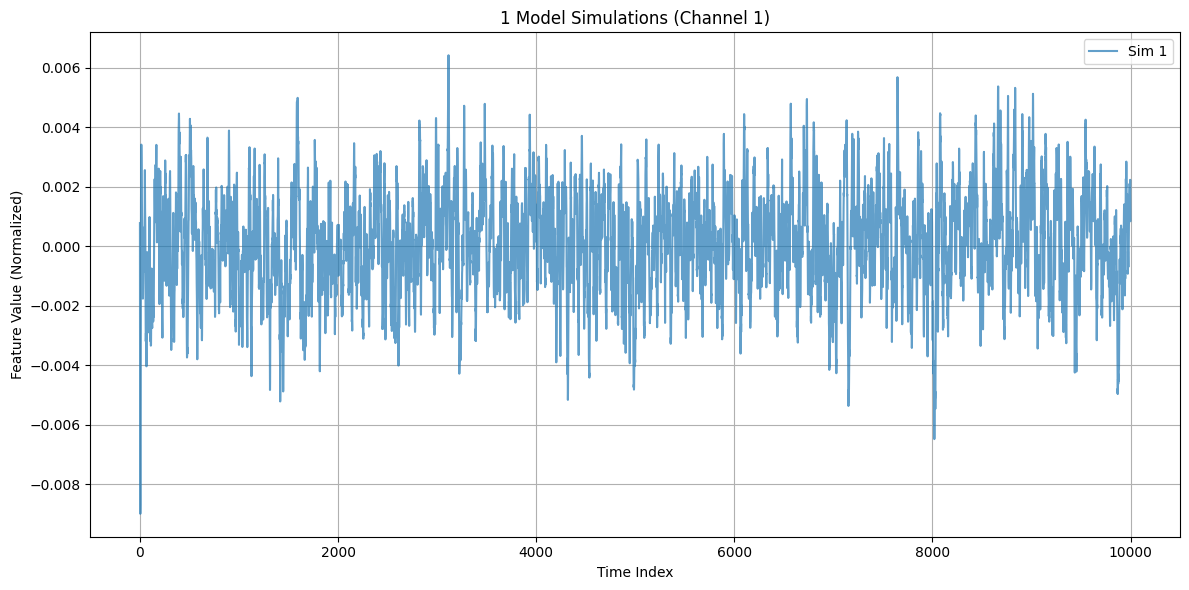

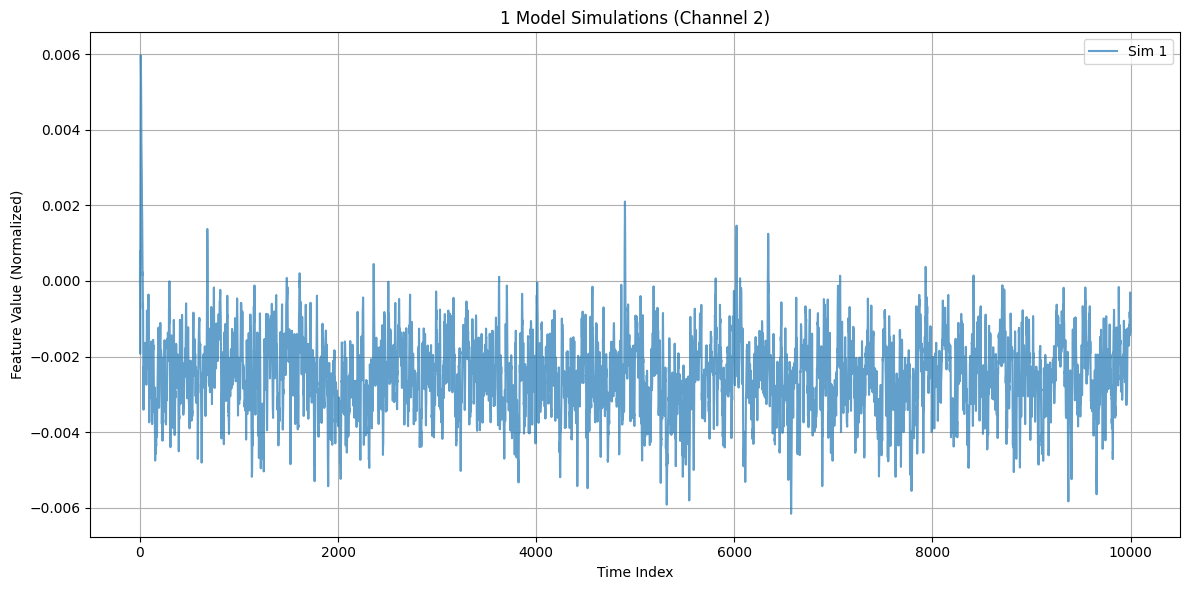

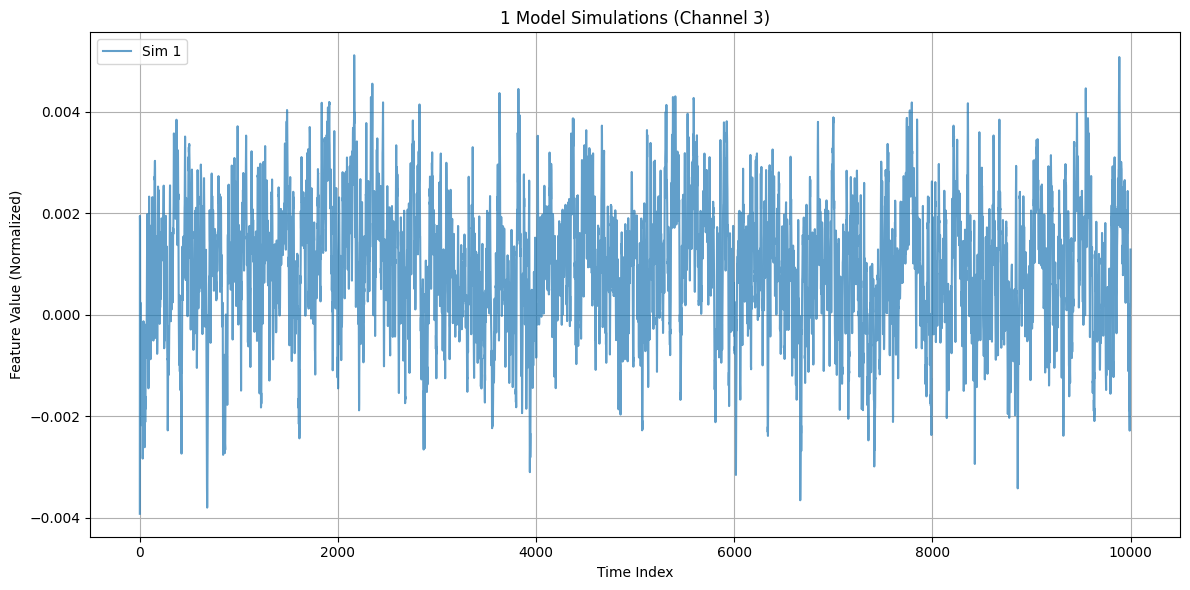

In [ ]:
plot_model_simulations_mean_dt(model=time_gan, num_simulations=1, sequence_length=10000)

### QuantGAN

In [ ]:
seq_length = train_data_np.shape[1]
num_channels = train_data_np.shape[2]

print("\n" + "=" * 50)
print("Training QuantGAN")
print("=" * 50)

quant_gan = QuantGAN(
    seq_length=seq_length,
    num_features=num_channels,
    embedding_dim=3,
    hidden_dim=80,
    lr=0.0002,
    clip_value=0.01,
    n_critic=5
)

print(f"QuantGAN model initialized on device: {quant_gan.device}")

print("Training QuantGAN model...")
quant_gan.fit(train_loader_np, num_epochs=10)
print("QuantGAN training complete.")


Training QuantGAN
QuantGAN model initialized on device: cpu
Training QuantGAN model...


  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\14165\Downloads\Unified-benchmark-for-SDGFTS-main\.env\Lib\site-packages\torch\nn\modules\conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1028.)
  return F.conv1d(
  0%|          | 0/10 [00:19<?, ?it/s]


KeyboardInterrupt: 

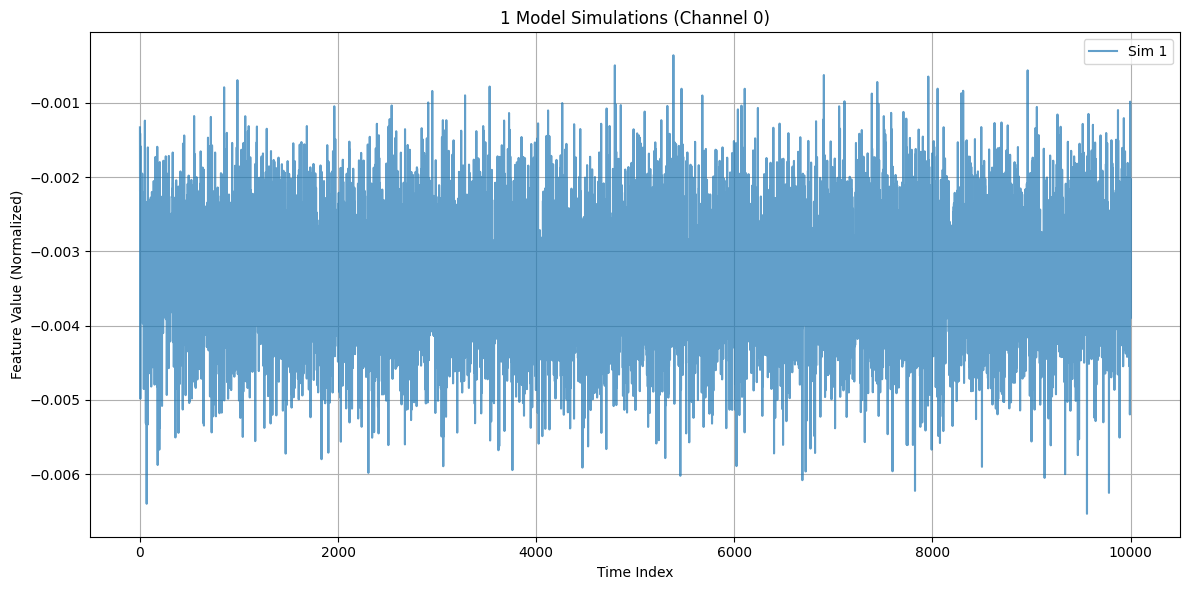

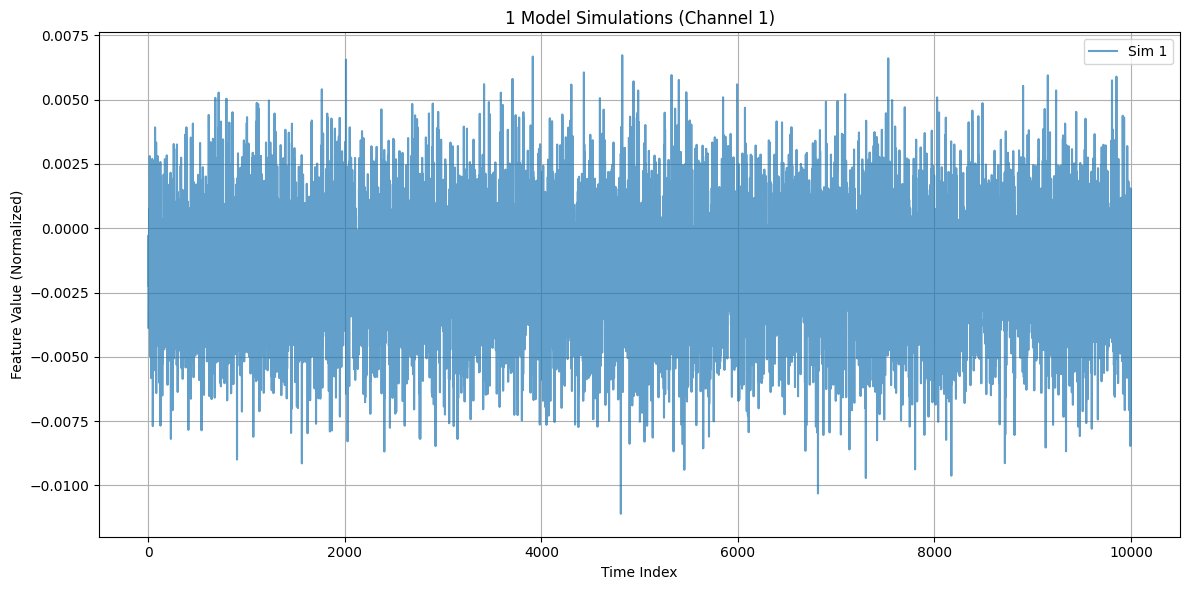

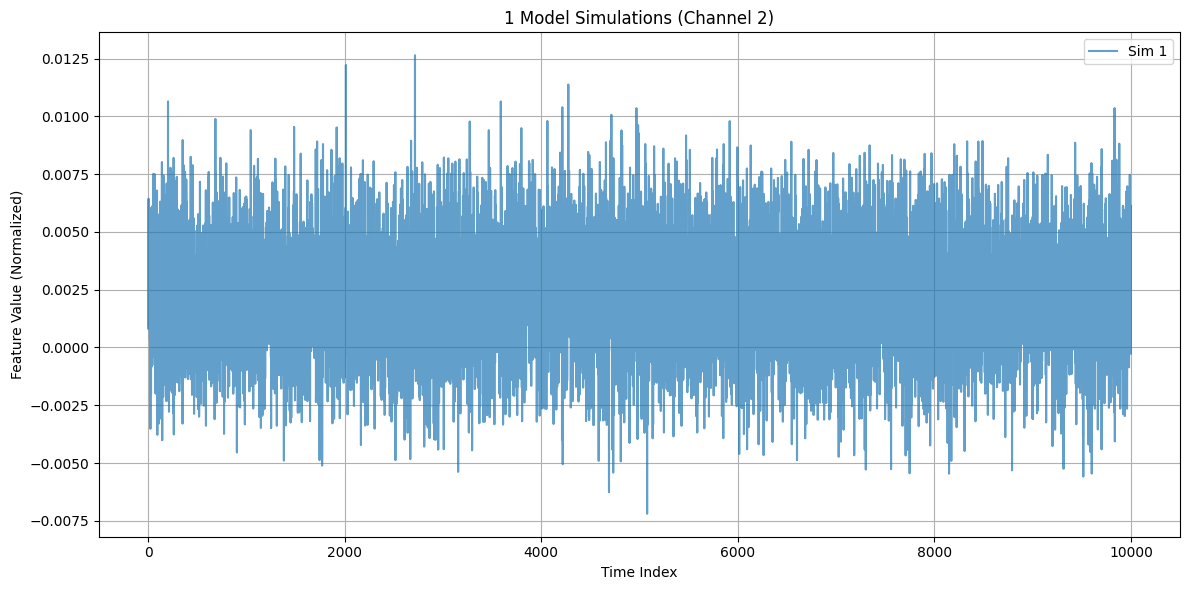

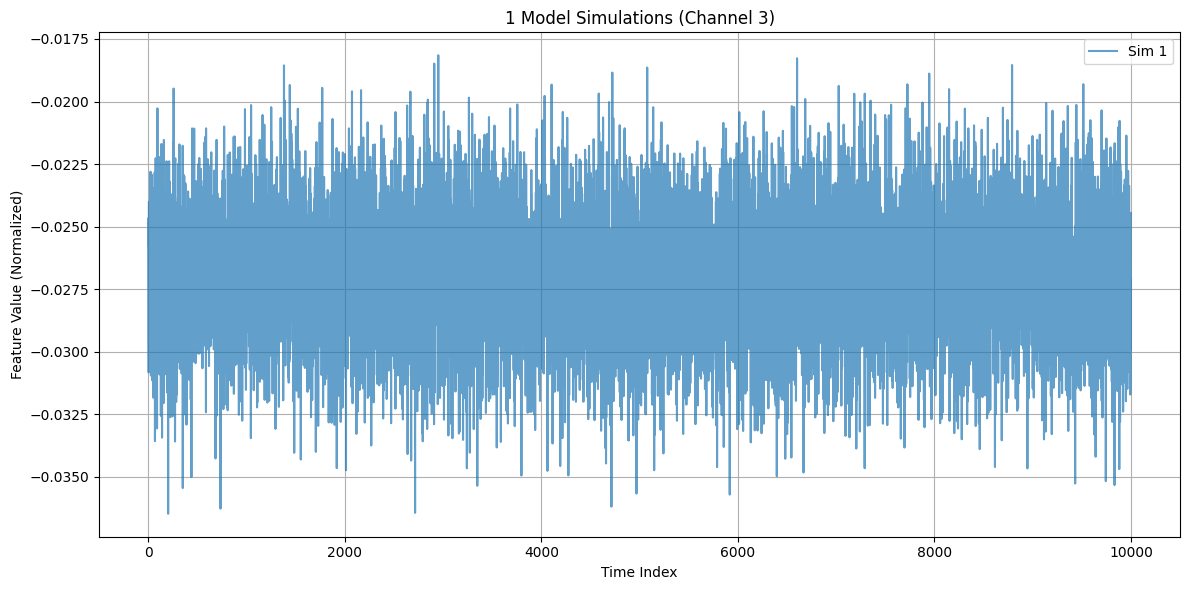

In [ ]:
plot_model_simulations_mean_dt(model=quant_gan, num_simulations=1, sequence_length=10000)

### TimeVAE

In [ ]:
seq_length = train_data_np.shape[1]
num_channels = train_data_np.shape[2]

print("\n" + "=" * 50)
print("Training TimeVAE")
print("=" * 50)

time_vae = TimeVAE(
    seq_length=seq_length,
    n_channels=num_channels,
    latent_dim=32,
    enc_hidden=128,
    dec_hidden=128,
    beta=1.0,
    use_lstm=True
)

print(f"TimeVAE model initialized on device: {time_vae.device}")

print("Training TimeVAE model...")
time_vae.fit(train_loader_np, epochs=10)
print("TimeVAE training complete.")


Training TimeVAE
TimeVAE model initialized on device: cpu
Training TimeVAE model...
Epoch 1/10 | loss: 0.001446 | recon: 0.001389 | kld: 0.000056


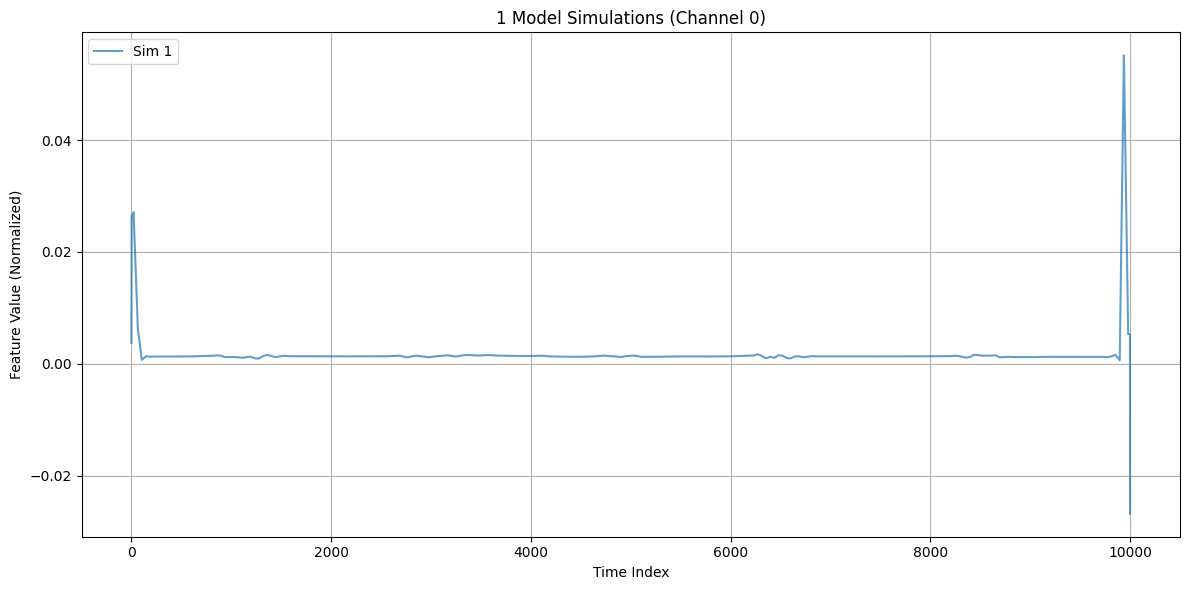

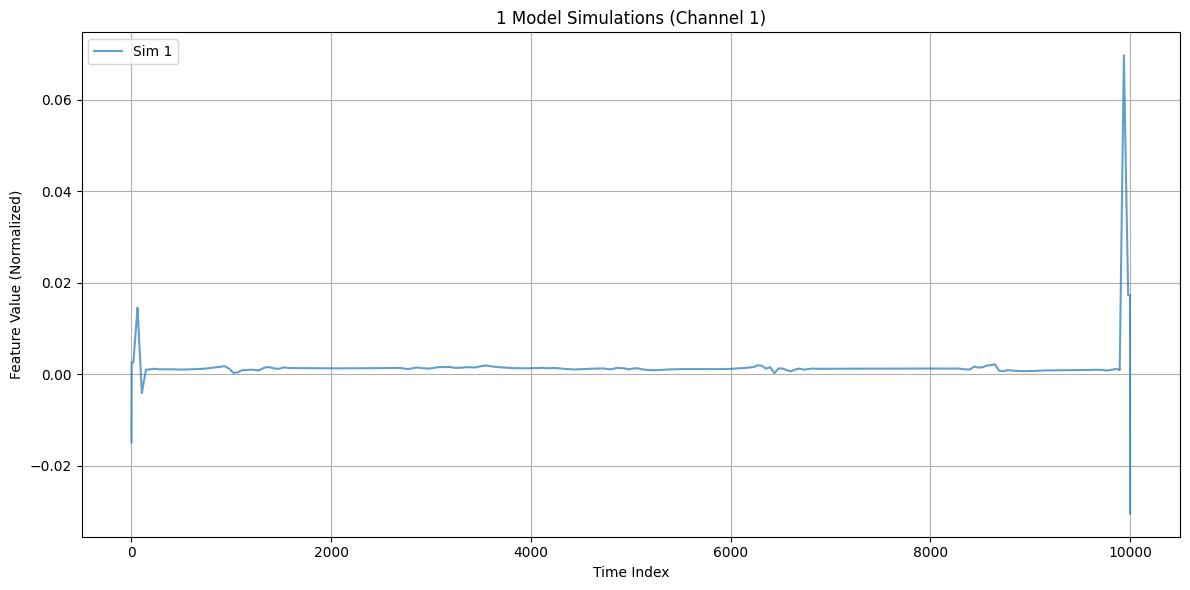

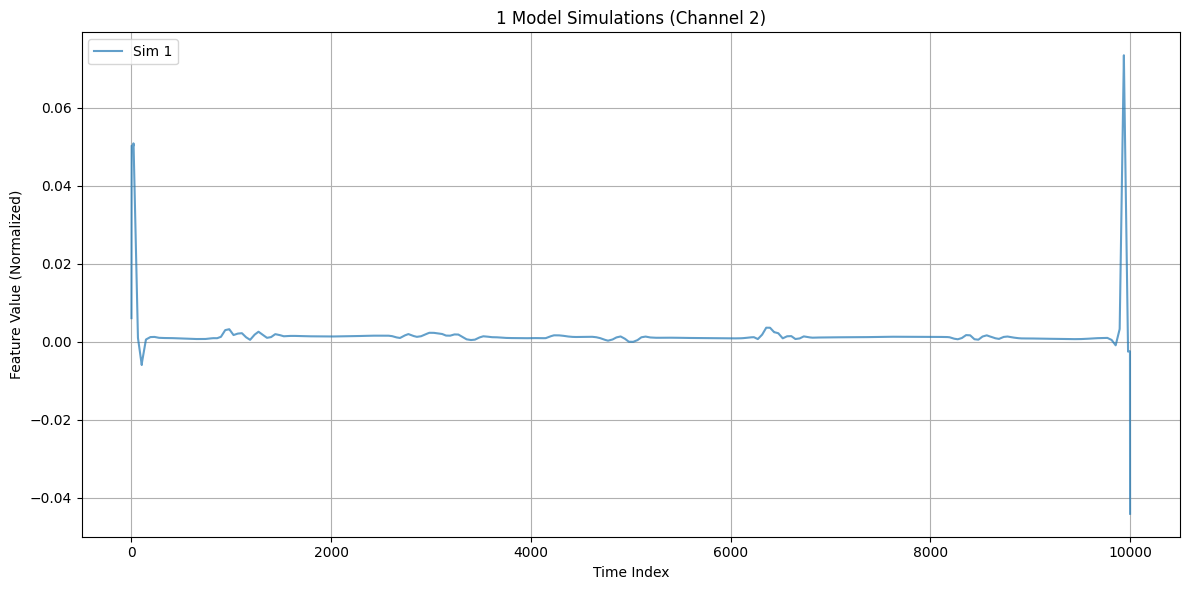

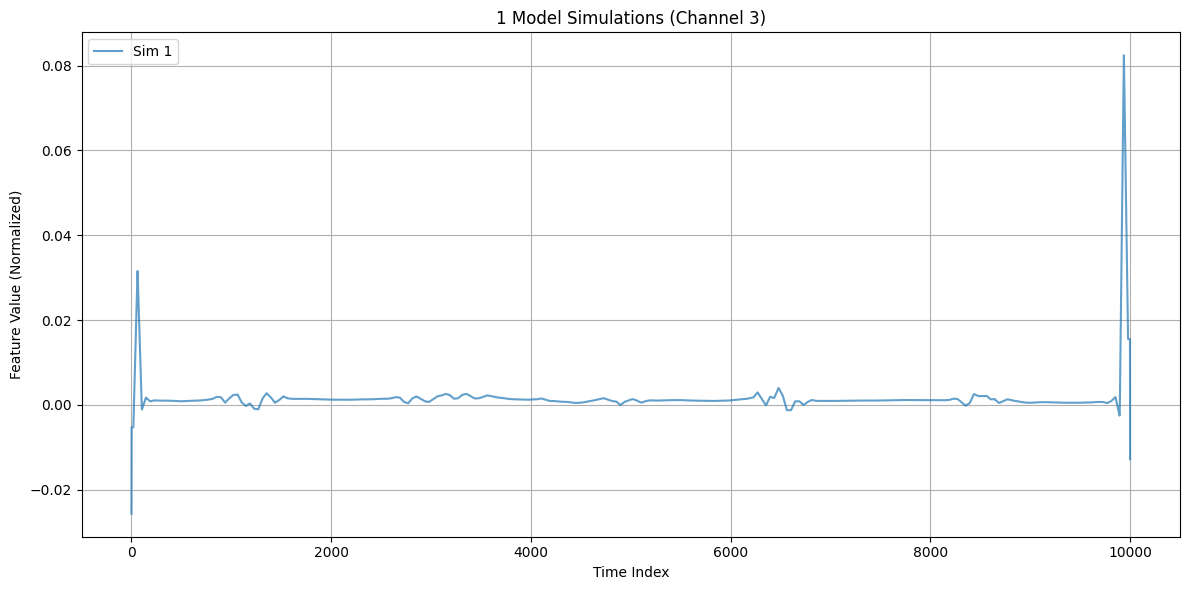

In [ ]:
plot_model_simulations_mean_dt(model=time_vae, num_simulations=1, sequence_length=10000)

### Sig-WGAN


In [ ]:
seq_length = train_data_np.shape[1]
num_channels = train_data_np.shape[2]

print("\n" + "=" * 50)
print("Training Sig-WGAN")
print("=" * 50)

sig_wgan = SigWGAN(
    seq_length=seq_length,
    num_features=num_channels,
    embedding_dim=3,
    hidden_dim=80,
    lr=0.0002,
    clip_value=0.01,
    n_critic=5
)

print(f"Sig-WGAN model initialized on device: {sig_wgan.device}")

print("Training Sig-WGAN model...")
sig_wgan.fit(train_loader_np, num_epochs=1)
print("Sig-WGAN training complete.")

In [ ]:
plot_model_simulations_mean_dt(model=sig_wgan, num_simulations=1, sequence_length=10000)